In [83]:
import csv
import os
import pandas as pd
import torch
import torch.optim as optim
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from time import time
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [84]:
def create_csv(root_folder, output_csv):
    with open(output_csv, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['image_filename', 'label'])

        for label in os.listdir(root_folder):
            label_path = os.path.join(root_folder, label)
            if os.path.isdir(label_path):
                for image_filename in os.listdir(label_path):
                    image_path = os.path.join(label, image_filename)
                    label_value = int(label)
                    writer.writerow([image_path, label_value])

# Specify the path to your "Train" and "Test" dataset folders
train_dataset_folder = 'Train/'
test_dataset_folder = 'Test/'
validation_dataset_folder = "Validation/"

# Create the CSV files
create_csv(train_dataset_folder, "Train/train.csv")
create_csv(test_dataset_folder, "Test/test.csv")
create_csv(validation_dataset_folder, "Validation/validation.csv")

print('CSV files created.')

CSV files created.


In [85]:
class AIDER(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])

        # Use PIL to open and transform the image
        image = Image.open(img_path).convert('RGB')

        label = int(self.img_labels.iloc[idx, 1])  # Convert label to integer
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)

        # Convert label to torch.LongTensor
        label = torch.LongTensor([label])
        return image, label

In [86]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'googlenet', pretrained=False)
in_features = model.fc.in_features
model.fc = torch.nn.Linear(in_features, 5)

Using cache found in C:\Users\최신우/.cache\torch\hub\pytorch_vision_v0.10.0
C:\Users\최신우\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\최신우\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
C:\Users\최신우\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\googlenet.py:47: FutureWarning: The default weight initialization of GoogleNet will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.

In [87]:
training_data = AIDER(
    annotations_file="Train/train.csv",
    img_dir="Train/",
    transform=transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
)

test_data = AIDER(
    annotations_file="Test/test.csv",
    img_dir="Test/",
    transform=transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
)

validation_data = AIDER(
    annotations_file="Validation/validation.csv",
    img_dir="Validation/",
    transform=transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
)



train_loader = torch.utils.data.DataLoader(training_data, batch_size=32, shuffle=True, pin_memory=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=32, shuffle=False, pin_memory=True)
validation_loader = torch.utils.data.DataLoader(validation_data, batch_size=32, shuffle=False, pin_memory=True)

In [88]:
if torch.cuda.is_available():
    print("GPU is available.")
else:
    print("GPU is not available. Switching to CPU.")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
criterion = torch.nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
# Function to train the model
def train(model, train_loader, optimizer, criterion, num_epochs=5, print_every=10):
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        initial_time = time()
        prev_time = initial_time
        for i, (inputs, labels) in enumerate(train_loader, 1):
            optimizer.zero_grad()
            # Move inputs and labels to GPU
            inputs, labels = inputs.to(device), labels.to(device)
            outputs, *_ = model(inputs)
            loss = criterion(outputs, labels.squeeze())
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            # Print the loss every print_every batches
            if i % print_every == 0 or i == len(train_loader):
                avg_loss = running_loss / i
                print(f'Epoch {epoch + 1}/{num_epochs}, Batch {i}/{len(train_loader)}, Loss: {avg_loss}, Time taken since last batch: {time() - prev_time:.2f}s, Total time taken: {time() - initial_time:.2f}s')
                prev_time = time()
        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for inputs, labels in validation_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels.squeeze())
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                labels = labels.flatten()
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()
        # Calculate average validation loss
        avg_val_loss = val_loss / len(validation_loader)
        # Calculate accuracy
        accuracy_val = correct_val / total_val
        print(f'\nValidation Loss: {avg_val_loss}, Validation Accuracy: {100 * accuracy_val:.2f}%\n')
num_epochs = 200# You can adjust this value
print_every = 5  # Print loss every 10 batches
train(model, train_loader, optimizer, criterion, num_epochs, print_every)

GPU is available.
Epoch 1/200, Batch 5/114, Loss: 1.5142498016357422, Time taken since last batch: 2.06s, Total time taken: 2.06s
Epoch 1/200, Batch 10/114, Loss: 1.3069972157478333, Time taken since last batch: 1.60s, Total time taken: 3.66s
Epoch 1/200, Batch 15/114, Loss: 1.24602929353714, Time taken since last batch: 1.66s, Total time taken: 5.32s
Epoch 1/200, Batch 20/114, Loss: 1.2098620176315307, Time taken since last batch: 1.77s, Total time taken: 7.09s
Epoch 1/200, Batch 25/114, Loss: 1.185713927745819, Time taken since last batch: 1.81s, Total time taken: 8.91s
Epoch 1/200, Batch 30/114, Loss: 1.1473701258500417, Time taken since last batch: 1.67s, Total time taken: 10.58s
Epoch 1/200, Batch 35/114, Loss: 1.152069079875946, Time taken since last batch: 1.74s, Total time taken: 12.32s
Epoch 1/200, Batch 40/114, Loss: 1.1549370303750037, Time taken since last batch: 1.69s, Total time taken: 14.01s
Epoch 1/200, Batch 45/114, Loss: 1.1371914241049024, Time taken since last batch

In [89]:
# Evaluate the model on the test set
model.eval()
correct = 0
total = 0
predicted_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        # Move inputs and labels to GPU
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        labels = labels.flatten()
        predicted = predicted.flatten()
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Append the predicted labels to the list
        predicted_labels.extend(predicted.tolist())

accuracy = correct / total
print(f'Test Accuracy: {100 * accuracy:.2f}%')

Test Accuracy: 85.10%


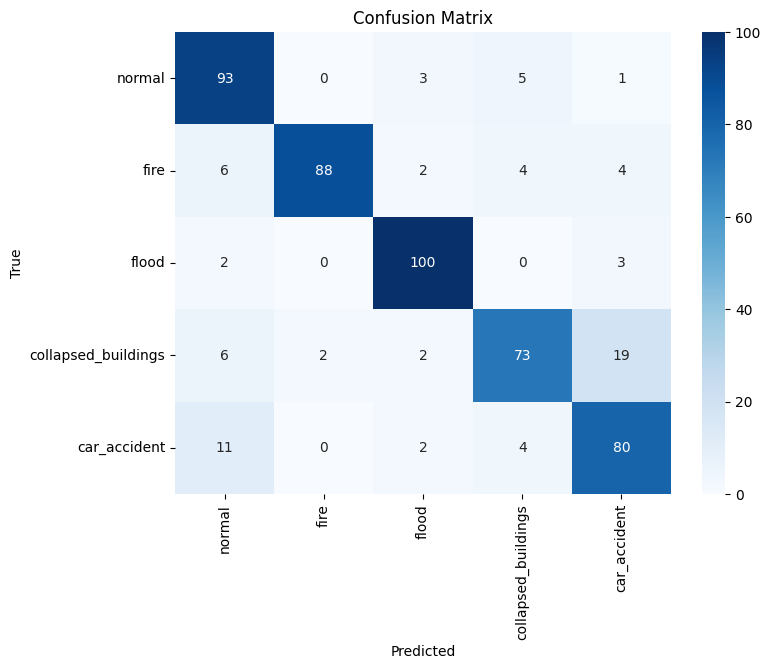

In [95]:
def plot_confusion_matrix(true_labels, predicted_labels, class_names):
    # Convert class names to indices for plotting
    cm = confusion_matrix(true_labels, predicted_labels)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

class_mapping = {0: 'normal', 1: 'fire', 2: 'flood', 3: 'collapsed_buildings', 4: 'car_accident'}

predicted_labels = np.array(predicted_labels)
true_labels = [class_mapping[label] for label in test_data.img_labels['label']]
true_labels = np.array([list(class_mapping.keys())[list(class_mapping.values()).index(label)] for label in true_labels])
# Plot the confusion matrix
plot_confusion_matrix(true_labels, predicted_labels, class_mapping.values())